# Optimización de red neuronal con KerasTuner (capas profundas)


Este notebook utiliza **KerasTuner** para encontrar la mejor arquitectura de red neuronal para el dataset de California Housing,
manteniendo el preprocesamiento definido en `preprocessing.py`.

Se exploran:
- Número de capas ocultas (hasta 4)
- Unidades por capa
- Función de activación (`relu`)
- Dropout
- Tasa de aprendizaje


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from preprocessing import get_preprocessor
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


In [2]:

housing = pd.read_csv("housing.csv").dropna()
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

preprocessor = get_preprocessor(housing)
X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)


In [3]:

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=X_train_prep.shape[1]))
    
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
            activation="relu"
        ))
        model.add(keras.layers.Dropout(rate=hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)))
    
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse"
    )
    return model


In [4]:

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="kt_dir",
    project_name="housing_nn_tuner"
)

tuner.search(X_train_prep, y_train_scaled, epochs=100,
             validation_data=(X_valid_prep, y_valid_scaled),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Trial 10 Complete [00h 00m 38s]
val_loss: 0.18264269828796387

Best val_loss So Far: 0.17517998814582825
Total elapsed time: 00h 09m 10s


In [5]:

best_model = tuner.get_best_models(1)[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               9600      
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               123200    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 321       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


128/128 [==============================] - 0s 710us/step
✅ RMSE test (modelo óptimo con KerasTuner): 50828.93805638707


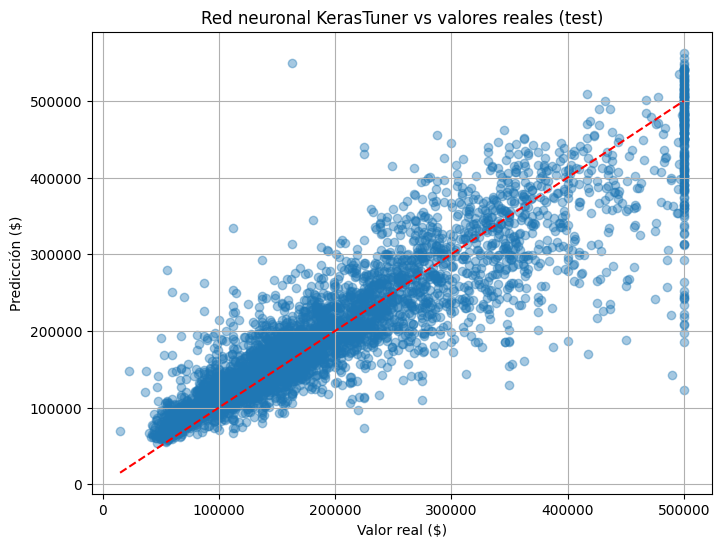

In [6]:

y_test_pred_scaled = best_model.predict(X_test_prep)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("✅ RMSE test (modelo óptimo con KerasTuner):", rmse_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valor real ($)")
plt.ylabel("Predicción ($)")
plt.title("Red neuronal KerasTuner vs valores reales (test)")
plt.grid(True)
plt.show()
